In [1]:

import os
import sys
import warnings
import math
import torch
import torchvision
from torch import nn
from tqdm import tqdm
from math import prod
from torchinfo import summary

#
# ~~~ Paul's utils (thanks Paul!)
from utils.data_handling import metadata_df, EegDataset



In [2]:
#
# ~~~ Tom's utils (YOU MAY NEED TO MODIFY THESE IMPORT STATEMENTS AND THE IMPORT STATEMENTS THEREIN)
from Toms_dependencies.quality_of_life.my_torch_utils import JL_layer, convert_Dataset_to_Tensors
#from all_brains_2.Toms_utils import train_val_split
from Toms_dependencies.fit import fit, count_percent_nonzero_grads, compute_ell_1_norm_of_params, compute_ell_2_norm_of_params


# warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(3042024)  # ~~~ lr=1e-2, b=100, ReLU arch. A with JL (52,546,156 trainable), stagnates after 2 epochs
torch.manual_seed(3092024)  # ~~~ same lr, etc. as previuos seed, same results
torch.manual_seed(3092024)  # ~~~ much bigger lr=10. but otherwise same as previous two
torch.manual_seed(3192024)  # ~~~ architecture E with and without dropout (p=0.5 immediately before the final linear layer)


In [21]:
import numpy as np
def train_val_split( metadata, val_frac=0.2, seed=4, verbose=True ):
    #
    # ~~~ Count the "true" sizes of our datasets (each case has multiple spectrograms, and we want "a datapoint" to be a complete case, not just 1 spectrogram)
    cases = metadata.eeg_id.unique()    # ~~~ a "single case" is represented my multiple "rows" of data
    n_cases = len(cases)            # ~~~ number of different cases represented by our training set
    n_val = round(val_frac*n_cases) # ~~~ number of different cases that we want in the validation set
    if verbose:
        print(f"{n_cases} unique eegs, using {n_val} for validation set.")
    #
    # ~~~ Split the data not by "rows" but, rather, in a manner that respects the "grouped" nature of our data
    rng = np.random.default_rng(seed=seed)
    val_idx = rng.choice( cases, size=n_val, replace=False )
    metadata_train = metadata[~metadata.eeg_id.isin(val_idx)]
    metadata_valid = metadata[metadata.eeg_id.isin(val_idx)]
    if verbose:
        print("")
        print(f"{len(metadata_train)} training items, {len(metadata_valid)} validation items.")
        print("")
    return metadata_train, metadata_valid, val_idx
# ~~~ Load the data
#metadata = metadata_df("train").iloc[0:190000:100]
metadata = metadata_df('train')
metadata_train, metadata_test, _ = train_val_split( metadata, val_frac=0.05, seed=4, verbose=True )


1002 unique eegs, using 50 for validation set.

1018 training items, 50 validation items.



In [24]:
### ~~~
## ~~~ Build the network
### ~~~

D = 190000  # ~~~ the dimension 400*300 of one spectrogram
d = 10000   # ~~~ a desired smaller dimension
use_JL = False
in_dim = d if use_JL else D

#
# ~~~ This or whatever model you want
model = nn.Sequential(
            # JL_layer(D,d),          # ~~~ uncomment this line and set `use_JL=True` if you want to use JL (i.e., compressed data; though the compression saves little computational resources unless handled more thoughtfullly)
            nn.Linear(in_dim, 1000),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            # nn.Linear(1000, 1000),
            # nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(500, 50),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(50, 6),
            nn.LogSoftmax(dim=1)
        ).to(device)



### ~~~
## ~~~ Gather data
### ~~~

# ~~~ Define a pre-processing step
def flatten_and_standardize(x):
    x = x.flatten()                         # ~~~ flatten the matrix
    return (x-x.mean(dim=-1))/x.std(dim=-1) # ~~~ standardize it

#
# ~~~ Set up the dataset to include the pre-processing step
brains_train = EegDataset( metadata_train, item_transforms=flatten_and_standardize, normalize_targets=True )
test_data = convert_Dataset_to_Tensors(EegDataset( metadata_test, item_transforms=flatten_and_standardize, normalize_targets=True ))
X_test, y_test = test_data
X_test = X_test.to(device)
y_test = y_test.to(device)

#
# ~~~ Delete some stuff to free up a smidge of memory
# del test_data
# del metadata
# del metadata_train
# del metadata_test

Epoch 20/20: 100%|=========| 21/21 [02:04<00:00,  5.93s/it, loss=1.3175, percent nonzero grads=0.9909, test acc=0.1600]


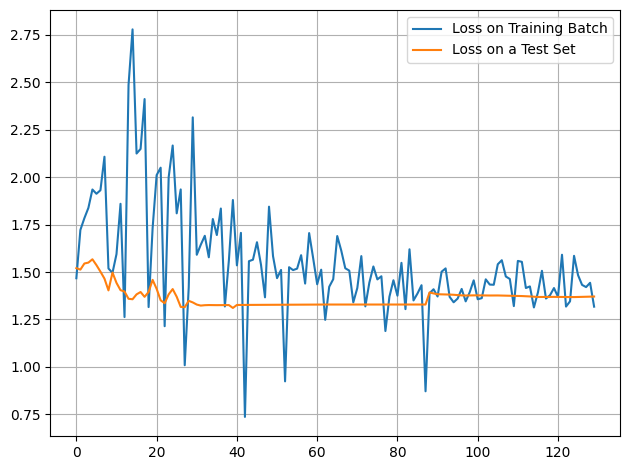

In [25]:
# ~~~ A metric that measures the model's accuracy on the supplied data
def measure_accuracy( model, data, **kwargs ):  # ~~~ allow arbitrary kwargs for compatibility with `fit`
    with torch.no_grad():
        X = data[0].to(device)  # ~~~ reference `device` from outside the scope of this function or as a kwarg
        y = data[1].to(device)
        p = model(X).argmax(dim=1)  
        t = y.argmax(dim=1)
        batch_size = len(y)
        n_correct = torch.sum( t==p ).item()
    return n_correct/batch_size

#
# ~~~ A metric that just computes the loss on whatever data is supplied
def compute_loss( model, data, loss_fn, optimizer ):
    with torch.no_grad():
        X,y = data
        X = X.to(device)    # ~~~ reference `device` from outside the scope of this function or as a kwarg
        y = y.to(device)
        loss = loss_fn(model(X),y).item()
    return loss

#
# ~~~ Compute both the loss and also the accuracy
def loss_and_acc( model, data, loss_fn, optimizer ):  # ~~~ allow arbitrary kwargs for compatibility with `fit`
    with torch.no_grad():
        X = data[0].to(device)  # ~~~ reference `device` from outside the scope of this function
        y = data[1].to(device)
        p = model(X).argmax(dim=1)
        t = y.argmax(dim=1)
        loss = loss_fn(model(X),y).item()
        batch_size = len(y)
        n_correct = torch.sum( t==p ).item()
    return loss, n_correct/batch_size



summary(model)


history = fit(
        model,
        dataloader  = torch.utils.data.DataLoader( brains_train, batch_size=50, shuffle=True ),
        test_data   = (X_test,y_test),
        loss_fn     = nn.KLDivLoss( reduction="batchmean" ),
        optimizer   = torch.optim.Adam( model.parameters(), lr=1e-4 ),
        training_metrics         = { "train acc":measure_accuracy },
        test_metrics             = { "test loss":compute_loss },
        epochal_training_metrics = { "percent nonzero grads":count_percent_nonzero_grads },
        epochal_test_metrics     = { "test acc":measure_accuracy },
        epochs = 2,
        just = 6, sig = 4,  # ~~~ try to print 4 significant digits while never using more than 5 characters
        #history = history if "history" in globals() else None
    )


#
# ~~~ Plot stuff

#
# ~~~ Compute the moving average of a list (this reduces the list's length)
def moving_average( list, window_size ):
    kernel = np.ones(window_size) / window_size
    return np.convolve( list, kernel, mode='valid' )

import matplotlib.pyplot as plt
plt.plot( moving_average(history["loss"],1), label="Loss on Training Batch" )
plt.plot( moving_average(history["test loss"],1), label="Loss on a Test Set" )
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()